In [63]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import random

class GA():

    def __init__(self, crossover_rate, mutation_rate, population_size):

        """
        Constructor of the GA class. Initialize parameters.
        :param crossover_rate: Crossover rate
        :param mutation_rate: Mutation rate
        :param population_size: Size of the population
        """

        self.pop_size = population_size
        self.n_generations = 200
        self.tournament_size = 5
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_size = 2 

        # Stocks
        self.stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'LLY', 'AVGO', 'TSLA', 'JPM', 'UNH', 'V', 'XOM', 'MA', 'JNJ']

        # S&P 500 Index
        self.market_index = '^GSPC'

        self.start_date = '2012-05-20'
        self.end_date = '2022-12-31'
        self.test_start_date = '2023-01-01'
        self.test_end_date = '2024-01-01'

        # Getting the data
        self.data = yf.download(self.stocks, start=self.start_date, end=self.end_date)['Adj Close']
        self.test_data = yf.download(self.stocks, start=self.test_start_date, end=self.test_end_date)['Adj Close']
        self.market_data = yf.download(self.stocks  + [self.market_index], start=self.test_start_date, end=self.test_end_date)['Adj Close']

        self.returns = self.data.pct_change().dropna()
        self.test_returns = self.test_data.pct_change().dropna()
        self.market_returns = self.market_data.pct_change().dropna()

        # S&P500 Returns
        self.market_returns = self.market_returns[self.market_index]

        # Daily average returns and covariance matrix
        self.mean_returns = self.returns.mean()
        self.cov_matrix = self.returns.cov()

        # Risk-free rate as a percentage
        self.risk_free_rate = 0.9524 / 100 # 0.9524 is the Mean of 1 Year Treasury Bill Price Between 20/05/2012 and 31/12/2022 

    def create_individual(self):
        """
            Randomly generates portfolio weights
            :return: Generated weights
        """
        weights = np.random.random(len(self.stocks))
        weights /= np.sum(weights)
        return weights

    def fitness(self, individual):
        """
            Calculates fitness score (sharpe ratio)
            :param individual: Represents an individual of the population
            :return: Sharpe ratio
        """
        portfolio_return = np.sum(self.mean_returns * individual) * 252
        portfolio_volatility = np.sqrt(np.dot(individual, np.dot(self.cov_matrix * 252, individual)))
        sharpe_ratio = (portfolio_return - self.risk_free_rate) / portfolio_volatility
        return sharpe_ratio

    def tournament_selection(self, population, scores, k):
        """
            Applies tournament selection
            :param population: Represents the population
            :param scores: Fitness scores
            :param k: Tournament size
            :return: Tournament winner
        """
        selection_idx = np.random.choice(range(len(population)), k, replace=False)
        selected_idx = np.argmax([scores[idx] for idx in selection_idx])
        return population[selection_idx[selected_idx]]

    def normalize(self, weights):
        """
            Normalizes the portfolio weights
            :param weights: Portfolio weights
            :return: Normalized portfolio weights
        """
        weights = [max(0, w) for w in weights] 
        total = sum(weights)
        return [max(0, w) / total for w in weights]
        
    def crossover(self, parent1, parent2):
        """
            Applies arithmetic crossover
            :param parent1: First parent
            :param parent2: Second parent
            :return: Created children
        """
        if random.random() < self.crossover_rate:
            alpha = random.random()
            child1 = [alpha * p1 + (1 - alpha) * p2 for p1, p2 in zip(parent1, parent2)]
            child2 = [alpha * p2 + (1 - alpha) * p1 for p1, p2 in zip(parent1, parent2)]
            return [self.normalize(child1), self.normalize(child2)]
        else:
            return [parent1.copy(), parent2.copy()]

    def mutate(self, individual):
        """
            Mutates the individual
            :param individual: Represents an individual of the population
            :return: Mutated individual
        """
        if random.random() < self.mutation_rate:
            mutation_idx = random.randint(0, len(individual) - 1)
            individual[mutation_idx] += np.random.normal(0, 0.1)
            individual = self.normalize(individual)
        return individual
    
    def algorithm(self):
        """
            GA implementation
            :return: Mutated individual
        """

        # Generating population
        population = [self.create_individual() for _ in range(self.pop_size)]

        best_sharpe_ratios = []

        # Evolution
        for _ in range(self.n_generations):

            # Fitness evaluation
            fitness_scores = [self.fitness(individual) for individual in population]

            # Storing best individual's fitness score 
            best_sharpe_ratios.append(max(fitness_scores))
            
            # Elitism
            sorted_indices = sorted(range(len(population)), key=lambda i: fitness_scores[i], reverse=True)
            elites = [population[i] for i in sorted_indices[:self.elitism_size]]
            
            # Selection, crossover, mutation
            new_population = elites[:]
            while len(new_population) < self.pop_size:
                parent1 = self.tournament_selection(population, fitness_scores, self.tournament_size)
                parent2 = self.tournament_selection(population, fitness_scores, self.tournament_size)
                for child in self.crossover(parent1, parent2):
                    new_population.append(self.mutate(child))
            
            population = new_population[:]

        return population, best_sharpe_ratios

    def test_performance(self, weights):
        """
            Calculates return on test data
            :param weights: Optimized portfolio weights
            :return: Calculated portfolio return on test data
        """
        weights = self.normalize(weights)
        test_port_return = np.dot(weights, self.test_returns.mean()) * 252

        return test_port_return
    
    def show_sharpe_ratios_with_different_parameters(self, sharpe_ratios):
        """
            Shows sharpe ratios in one graph for different parameters
            :param sharpe_ratios: Sharpe ratios 
        """
        plt.xlabel('Generation')
        plt.ylabel('Sharpe Ratio')
        plt.title('Comparison of Optimized Portfolios Sharpe Ratios Created with Different Parameter Values')
        plt.plot(range(0,200), sharpe_ratios[0], label = "CR : 0.7, MR : 0.7, PSİZE : 100") 
        plt.plot(range(0,200), sharpe_ratios[1], label = "CR : 0.3, MR : 0.7, PSİZE : 100")
        plt.plot(range(0,200), sharpe_ratios[2], label = "CR : 0.7, MR : 0.3, PSİZE : 100") 
        plt.plot(range(0,200), sharpe_ratios[3], label = "CR : 0.7, MR : 0.7, PSİZE : 300")  
        plt.legend() 
        plt.show()

    def run(self, number_of_tests, show_graphs):

        """
            Runs algorithm \"number_of_tests\" times. Calculates average return and prints plots
            :param number_of_tests: Specifies how many times the test will be performed
            :return: Average return of created optimized portfolios and array of sharpe ratios over generations
        """

        test_returns = []
        sharpe_ratios = []
        best_portfolios = []

        for i in range(self.n_generations):
            sharpe_ratios.append([])

        for i in range(number_of_tests):

            population, best_sharpe_ratios = self.algorithm()

            for q in range(self.n_generations):
                sharpe_ratios[q].append(best_sharpe_ratios[q])

            best_index = np.argmax([self.fitness(ind) for ind in population])
            best_portfolio = population[best_index]
            best_portfolios.append(best_portfolio)

            test_return = self.test_performance(best_portfolio)
            test_returns.append(test_return)

        sharpe_ratios_over_generations = [sum(s_ratio) / len(s_ratio) for s_ratio in sharpe_ratios]

        if show_graphs:

            plt.plot(range(0,number_of_tests), [ret * 100 for ret in test_returns])
            plt.xlabel('Iteration')
            plt.ylabel('% Return')
            plt.title('Returns of the Optimized Portfolios On Test Data')
            plt.show()

            plt.plot(range(0,self.n_generations), sharpe_ratios_over_generations)
            plt.xlabel('Generation')
            plt.ylabel('Sharpe Ratio')
            plt.title('Sharpe Ratio of the Optimized Portfolio In Each Generation')
            plt.show()

            cummulative_market_return = (self.market_returns + 1).prod() - 1
            print(f"S&P 500 Return : {cummulative_market_return:.2%}")

            plt.bar(["Return of the Optimized Portfolio In "+str(number_of_tests)+" Iteration", "S&P500 Index Return"], [sum(test_returns) / len(test_returns) * 100, cummulative_market_return * 100], color ='maroon', width = 0.4)
            plt.ylabel('% Return')
            plt.title('Comparison of the Return of the Optimized Portfolio and the Return of the S&P 500 Between 01/01/2023 - 01/01/2024')
            plt.show()  

            total_portfolio_weights = np.zeros(len(self.stocks))
            average_portfolio_weights = []

            for best_portfolio in best_portfolios:
                for i, weight in enumerate(best_portfolio):
                    total_portfolio_weights[i] += weight
                
            average_portfolio_weights = [weight / number_of_tests for weight in total_portfolio_weights]

            for stock, weight in zip(self.stocks, average_portfolio_weights):
                print(f"{stock}: {weight:.2%}")

            plt.rcParams['font.size'] = 7

            plt.bar(self.stocks, [weight * 100 for weight in average_portfolio_weights], color ='green', width = 0.8)
            plt.xlabel('Stocks')
            plt.ylabel('% Weight')
            plt.title('Stock Weights in the Optimized Portfolio')
            plt.show()  


        return [sum(test_returns) / len(test_returns), sharpe_ratios_over_generations]
    


[*********************100%%**********************]  15 of 15 completed
[*********************100%%**********************]  15 of 15 completed
[*********************100%%**********************]  16 of 16 completed
[*********************100%%**********************]  15 of 15 completed
[*********************100%%**********************]  15 of 15 completed
[*********************100%%**********************]  16 of 16 completed
[*********************100%%**********************]  15 of 15 completed
[*********************100%%**********************]  15 of 15 completed
[*********************100%%**********************]  16 of 16 completed
[*********************100%%**********************]  15 of 15 completed
[*********************100%%**********************]  15 of 15 completed
[*********************100%%**********************]  16 of 16 completed


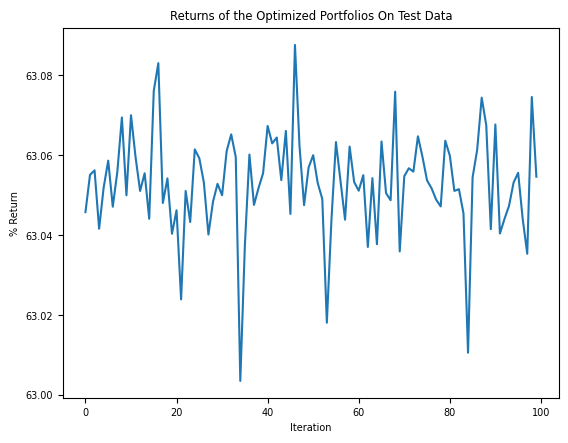

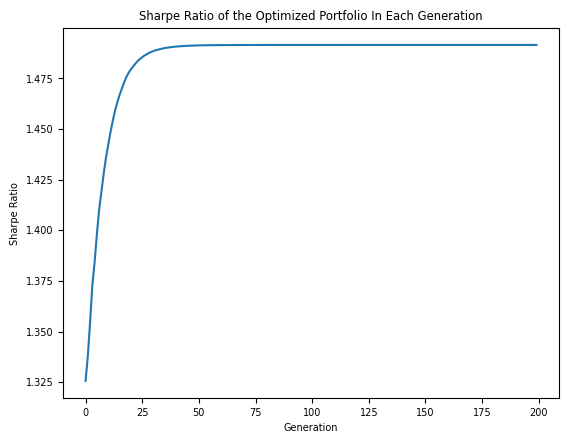

S&P 500 Return : 24.73%


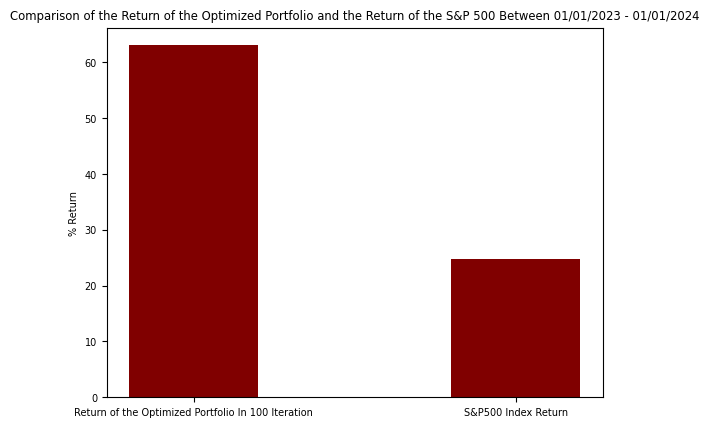

AAPL: 0.00%
MSFT: 0.00%
GOOG: 11.82%
AMZN: 0.00%
NVDA: 0.00%
META: 0.00%
LLY: 36.15%
AVGO: 0.00%
TSLA: 0.00%
JPM: 0.00%
UNH: 14.13%
V: 14.49%
XOM: 23.42%
MA: 0.00%
JNJ: 0.00%


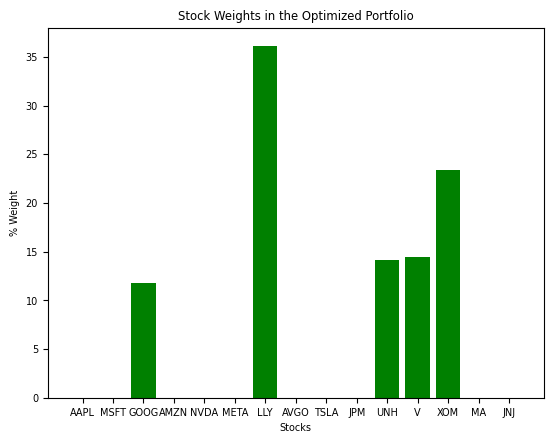

Portfolio Return GA-1 : 63.05%
Portfolio Return GA-2 : 63.05%
Portfolio Return GA-3 : 63.05%
Portfolio Return GA-4 : 63.05%


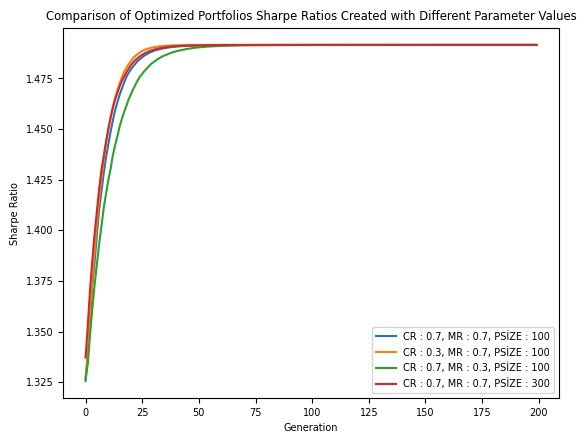

In [64]:
ga = GA(0.7, 0.7, 100)
ga_1 = GA(0.3, 0.7, 100)
ga_2 = GA(0.7, 0.3, 100)
ga_3 = GA(0.7, 0.7, 300)
average_return_1, sharpe_ratios_1 = ga.run(100, True)
print(f"Portfolio Return GA-1 : {average_return_1:.2%}")
average_return_2, sharpe_ratios_2 = ga_1.run(100, False)
print(f"Portfolio Return GA-2 : {average_return_2:.2%}")
average_return_3, sharpe_ratios_3 = ga_2.run(100, False)
print(f"Portfolio Return GA-3 : {average_return_3:.2%}")
average_return_4, sharpe_ratios_4 = ga_3.run(100, False)
print(f"Portfolio Return GA-4 : {average_return_4:.2%}")

ga.show_sharpe_ratios_with_different_parameters([sharpe_ratios_1, sharpe_ratios_2, sharpe_ratios_3, sharpe_ratios_4])